In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, MLtraining, visualisation

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
from scipy.stats import ttest_ind, pearsonr
import pandas as pd

# 2. Data Exploration

The general work is to perform mass univariate tests to each feature and then see which is highly associatated with PRS

In [4]:
# performing univariate test to individual connections to identify which region is highly associated with prs pval.

In [5]:
european_diffusion_dataset_term = pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_term_dataset.csv')

european_volumetric_dataset_term = pd.read_csv('./preprocessed_data/volumetric/term/european_volumetric_term_dataset.csv')

european_microstructure_dataset_term = pd.read_csv('./preprocessed_data/microstructure/term/european_microstructure_term_dataset.csv')


mixed_diffusion_dataset_term = pd.read_csv('./preprocessed_data/diffusion/term/mixed_diffusion_term_dataset.csv')

mixed_volumetric_dataset_term = pd.read_csv('./preprocessed_data/volumetric/term/mixed_volumetric_term_dataset.csv')

In [6]:
#### I have removed these 2 individuals because they have abnormally high WM content and low WM content ID- appears to be outliers when plotting their WM values- ID- CC00824XX16 - european and ID- CC00450XX05####
def remove_outliers_by_subject_ID(df,subject_ID=None):
    new_df = df.copy()
    for ID in subject_ID:
        idx_to_remove = new_df['ID'][new_df['ID'] == ID].index
        new_df = new_df.drop(idx_to_remove).reset_index(drop = True)
    return new_df

european_volumetric_dataset_term = remove_outliers_by_subject_ID(european_volumetric_dataset_term,subject_ID=['CC00824XX16','CC00450XX05'])
mixed_volumetric_dataset_term = remove_outliers_by_subject_ID(mixed_volumetric_dataset_term,subject_ID=['CC00824XX16','CC00450XX05'])

european_microstructure_dataset_term = remove_outliers_by_subject_ID(european_microstructure_dataset_term,subject_ID=['CC00824XX16','CC00450XX05'])
# mixed_microstructure_dataset_term = remove_outliers_by_subject_ID(mixed_microstructure_dataset_term,subject_ID=['CC00824XX16','CC00450XX05'])


In [7]:
print('available number of subjects in each dataset before removing outliers')
pd.DataFrame({'Dataset':['Vol','Diff','Micro'],
             'euro_number':[european_volumetric_dataset_term.shape[0],european_diffusion_dataset_term.shape[0],european_microstructure_dataset_term.shape[0]],
              'mixed_number':[mixed_volumetric_dataset_term.shape[0],mixed_diffusion_dataset_term.shape[0],mixed_diffusion_dataset_term.shape[0]]})

available number of subjects in each dataset before removing outliers


,Dataset,euro_number,mixed_number
0,Vol,199,250
1,Diff,152,185
2,Micro,155,185


In [9]:
schizophrenia_high_scores_european = data_preprocessing.read_table_from_txt('./dataset/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_updated.gwas.all.score',add_EP=False)# this is the updated SCZ file 
# make sure that your PRS is the correct one.
schizophrenia_high_scores_european = schizophrenia_high_scores_european[['ID','0.05']].merge(european_volumetric_dataset_term[['ID','PRS_0.05']],how='inner')

schizophrenia_high_scores_european

,ID,0.05,PRS_0.05
0,CC00050XX01,-0.002514,-0.002514
1,CC00054XX05,-0.002526,-0.002526
2,CC00058XX09,-0.002609,-0.002609
3,CC00062XX05,-0.002306,-0.002306
4,CC00064XX07,-0.002468,-0.002468
...,...,...,...
194,CC00883XX18,-0.002446,-0.002446
195,CC00886XX21,-0.002644,-0.002644
196,CC00890XX17,-0.002363,-0.002363
197,CC00911XX12,-0.002385,-0.002385


In [10]:
# see MLtraining.Select_Features_Univariate function for description of how mass univariate is done.

def mass_univariate(df,cat_independentVar_cols=None,cont_indpendentVar_cols=None,dependentVar_cols=None,additional_info=None):
    model_summary = defaultdict(list)
    new_df = df.copy()
    cat_independentVar = pd.get_dummies(new_df[cat_independentVar_cols], columns=cat_independentVar_cols,drop_first=True)
    new_cat_independentVar_cols = cat_independentVar.columns.to_list()
    
    cont_indpendentVar = np.asarray(new_df.loc[:,cont_indpendentVar_cols])
    
    dependentVar = np.asarray(new_df.loc[:,dependentVar_cols])
    
    #Normalising the data
    if dependentVar.ndim == 1:
        dependentVar = dependentVar.reshape(-1,1)
    dependentVar = StandardScaler().fit_transform(dependentVar)
    if cont_indpendentVar.ndim == 1:
        cont_indpendentVar = cont_indpendentVar.reshape(-1,1)
    cont_indpendentVar = StandardScaler().fit_transform(cont_indpendentVar)
    if cat_independentVar.ndim ==1 :
        cat_independentVar = cat_independentVar.reshape(-1,1)
    independentVar = np.concatenate([cat_independentVar, cont_indpendentVar],axis = 1)
    independentVar = sm.add_constant(independentVar)

    #transform back to pandas to save the names# unnecessary but easy later
    independentVar = pd.DataFrame(independentVar,columns=['const']+new_cat_independentVar_cols+cont_indpendentVar_cols)
    dependentVar = pd.DataFrame(dependentVar,columns=dependentVar_cols)
    
    for feature in dependentVar_cols:
        last_model = sm.OLS(dependentVar.loc[:,feature],independentVar).fit()        
        result=[None]*(len(last_model.params)+len(last_model.pvalues))
        result[::2]=last_model.params
        result[1::2]=last_model.pvalues
        model_summary[feature].extend(result)

    
    model_summary=pd.DataFrame(model_summary).T
    list1=independentVar.columns.to_list()
    list2=['_coef','_pval']

    model_summary.columns=[i+n for i in list1 for n in list2]
    if additional_info:
        model_summary['Additional_info'] = additional_info
        model_summary.columns = [i+n for i in list1 for n in list2] +['Additional_info']
    
    return last_model, model_summary

In [11]:
def differences_across_percentages(df, dependentVar=None, independentVar=None,threshold=None,percentage=0.2, ancestry_PCs=None):

    measure = data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(df[dependentVar]),StandardScaler().fit_transform(df[independentVar]))
    
    high_risk, low_risk = data_preprocessing.high_low_risk_divide(data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(df[threshold]),StandardScaler().fit_transform(df[ancestry_PCs])),low_perc=percentage,high_perc=percentage)

    measure_df = pd.DataFrame({'measure':measure.reshape(-1),'risk':['high risk' if i in high_risk else 'low risk' if i in low_risk else np.nan for i in range(len(measure))]}).dropna()
    stats, pval = ttest_ind(measure_df[measure_df['risk']=='low risk']['measure'],measure_df[measure_df['risk']=='high risk']['measure'],equal_var=True)
    low_risk_mean = measure_df[measure_df['risk']=='low risk']['measure'].mean(axis=0)
    high_risk_mean = measure_df[measure_df['risk']=='high risk']['measure'].mean(axis=0)
    return low_risk_mean,high_risk_mean,pval
    

def draw_differences_across_percentages(df, dependentVar=None, independentVar=None,threshold=None, percentages = None, ancestry_PCs=None):
    


    plt.plot(percentages, [differences_across_percentages(df,dependentVar,independentVar,threshold,percentage,ancestry_PCs)[0] for percentage in percentages],'xg-',label='low risk')

    plt.plot(percentages, [differences_across_percentages(df,dependentVar,independentVar,threshold,percentage,ancestry_PCs)[1] for percentage in percentages],'ob-',label = 'high risk')
    
    p_val = [differences_across_percentages(df,dependentVar,independentVar,threshold,percentage,ancestry_PCs)[2] for percentage in percentages]

    print (p_val)
    


    

## Diffusion

Remove zero features

In [11]:
remove_zero_features = MLtraining.Retain_non_zero_features().fit(mixed_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
remove_zero_features.get_column_names(mixed_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns)

Retain_non_zero_features()

In [12]:
mixed_diffusion_term_mass_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in mixed_diffusion_dataset_term.columns if 'PRS' in i]):
    _,temp_model_summary = mass_univariate(mixed_diffusion_dataset_term,cat_independentVar_cols=['Gender'],cont_indpendentVar_cols=['GA_diff','PMA_diff','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5',threshold],dependentVar_cols=remove_zero_features.reduced_features_names.to_list())
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    mixed_diffusion_term_mass_univariate = mixed_diffusion_term_mass_univariate.append(temp_model_summary)

mixed_diffusion_term_mass_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


In [13]:
mixed_diffusion_term_mass_univariate.sort_values(by=['PRS_pval'],ascending=True)

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC2_pval,mixed_Anc_PC3_coef,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,threshold
1111,PreCUN.L_SPG.R,0.087793,0.373581,-0.178480,0.210361,0.039668,0.670327,-0.259497,0.005291,0.016730,...,0.509606,-0.107603,0.214320,-0.045024,0.549333,-0.020548,0.781241,0.276211,0.000133,PRS_1e-08
3288,PreCUN.L_SPG.R,0.086788,0.381243,-0.176437,0.217751,0.042636,0.648666,-0.259333,0.005525,0.018371,...,0.524126,-0.110416,0.205052,-0.044207,0.558347,-0.017624,0.812494,0.262210,0.000306,PRS_1e-07
5465,PreCUN.L_SPG.R,0.092840,0.348968,-0.188740,0.187303,0.044714,0.632670,-0.258808,0.005632,0.016584,...,0.498328,-0.108144,0.214362,-0.045483,0.547219,-0.015627,0.833410,0.260932,0.000321,PRS_1e-06
16929,THA.R_ANG.R,-0.018179,0.838920,0.036957,0.774524,-0.106237,0.208316,0.395584,0.000004,0.402697,...,0.000755,0.023750,0.764253,-0.081422,0.233324,0.009640,0.885933,0.276938,0.000409,PRS_0.05
19106,THA.R_ANG.R,-0.020278,0.821198,0.041224,0.750166,-0.110125,0.194136,0.401968,0.000003,0.406980,...,0.000743,0.020579,0.796149,-0.088011,0.199049,0.008180,0.903385,0.273588,0.000722,PRS_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18265,PoCG.R_HIP.R,0.117342,0.258794,-0.238552,0.112223,0.012416,0.899001,-0.084815,0.381471,-0.165028,...,0.273268,-0.005216,0.954833,-0.095246,0.229160,0.043568,0.576165,0.000009,0.999918,PRS_0.1
13118,IFGtriang.L_SFGdor.L,0.080256,0.437593,-0.163158,0.274269,0.125842,0.198467,0.031697,0.742568,-0.034031,...,0.352438,-0.221423,0.016121,-0.047084,0.550184,0.079478,0.305813,-0.000007,0.999930,PRS_0.01
19957,ACG.L_IFGoperc.L,0.102466,0.323583,-0.208310,0.164971,-0.003142,0.974372,0.167794,0.084241,0.191682,...,0.421713,0.111747,0.224949,0.014665,0.852729,-0.048768,0.531591,-0.000004,0.999971,PRS_0.5
23203,PUT.R_FFG.L,0.022781,0.828707,-0.046312,0.760584,-0.076981,0.438764,-0.080140,0.415170,-0.009705,...,0.055831,-0.087016,0.351565,0.078106,0.330964,-0.011567,0.883759,0.000002,0.999981,PRS_1


In [62]:
# mixed_diffusion_term_mass_univariate.to_csv('./preprocessed_data/diffusion/term/data_exploration/mixed_diffusion_term_mass_univariate.csv',index=False)

### Mutiple comparison corrections

by Bonferroni we need 0.05/27643= 1e-6 to account for multiple testing correction

#### Computing the effective number of independent tests performed

Meff= Meff_connections * Meff_prs_thresholds

Multiple-comparison corrected p-value thresholds= 0.05/Meff

https://neurogenetics.qimrberghofer.edu.au/matSpDlite/

In [64]:
PRS_thresholds=[i for i in mixed_diffusion_dataset_term.columns if 'PRS' in i]
PRS_thresholds_corr_matrix=np.corrcoef(mixed_diffusion_dataset_term.loc[:,PRS_thresholds],rowvar=False)
np.savetxt('./preprocessed_data/diffusion/term/data_exploration/mixed_PRS_threshold_corr_matrix',PRS_thresholds_corr_matrix,delimiter='\t')

The Meff_prs_thresholds is 3

In [65]:
connectivity_corr_matrix=np.corrcoef(mixed_diffusion_dataset_term[remove_zero_features.reduced_features_names.to_list()],rowvar=False)
np.savetxt('./preprocessed_data/diffusion/term/data_exploration/mixed_connectivity_corr_matrix',connectivity_corr_matrix,delimiter='\t')

The Meff_connections is 1353.983

0.05/(1353.983*3)=1e-5, therefore, the p-value to reach is 1e-5

The lowest P-value we got is 2e-4, so none of our connections survived the multiple comparison correction in this case.

#### Permutation

Here we permute the PRS values, while keeping the order of the other values the same, and generate the p-value null distribution

In [101]:
# run codes/executable_code/perm_univariate_test

In [91]:
! mkdir log/diffusion/term/perm_univariate_test_csv/

In [101]:
import glob
import pickle

count=0
for file in tqdm.tqdm(glob.glob('./log/diffusion/term/perm_univariate_test/*')):
    with open(file,'rb') as fp:
        temp_model=pickle.load(fp)
    diffusion_term_p_val_temp=list()
    for (threshold,threshold_dict) in temp_model.items():
        diffusion_term_p_val_temp.append(pd.DataFrame(threshold_dict).T)

    diffusion_term_p_val_temp=pd.concat(diffusion_term_p_val_temp)
    diffusion_term_p_val_temp.reset_index(level=diffusion_term_p_val_temp.index.names, inplace=True)
    diffusion_term_p_val_temp.columns=['Connection','const_pval','GA.at.birth_pval','PMA.at.birth_pval','Gender_pval','Anc_PC1_pval','Anc_PC2_pval','Anc_PC3_pval','prs_pval','PRS_threshold']
    diffusion_term_p_val_temp.to_csv(f'./log/diffusion/term/perm_univariate_test_csv/permuted_diffusion_term_p_val_{count}.csv',index=False)
    count+=1

100%|██████████| 1000/1000 [43:50<00:00,  2.63s/it]


(array([626., 199.,  97.,  33.,  18.,  10.,   9.,   5.,   2.,   1.]),
 array([9.71208302e-08, 1.07959372e-04, 2.15821624e-04, 3.23683875e-04,
        4.31546127e-04, 5.39408378e-04, 6.47270630e-04, 7.55132881e-04,
        8.62995132e-04, 9.70857384e-04, 1.07871964e-03]),
 <a list of 10 Patch objects>)

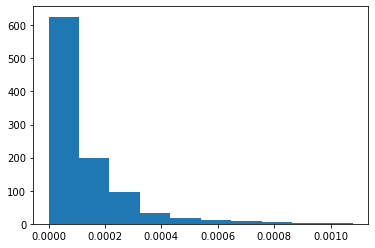

In [71]:
plt.hist(list(null_distribution))

#### Network based statistics:

Supra-threshold connections were considered if the p-value < 0.001



In [ ]:
### Choosing

The connectivity with significantly lower number of fibers in higher risk neonates identified by Shi et al., 2012 are 
- SOG.L_CAL.R (removed by preprocessing step)
- CUN.L_PCG.R (removed by preprocessing step)
- CAU.R_SOG.R 
- CAU.R_MOG.R
- PAL.R_PCL.R
- TPOmid.R_THA.R

Other identified in the adult neuroimaging (generally deals with white matter microstructure)
- Frontal lobe to Thalamus, cingulate gyrus
- Frontal lobe to Insula, hippocampus-amygdala, temporal and occipital lobes
- Dopaminergic pathways: Hippocampus, Amygdala, Caudate, Putamen, Pallidum, Thalmus


In [48]:
diffusion_term_p_val=pd.read_csv('./preprocessed_data/diffusion/term/obsv_diffusion_term_p_val.csv')

In [76]:
from statsmodels.stats.multitest import fdrcorrection
adjusted_p_val=fdrcorrection(diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in ['CAU.R_SOG.R','CAU.R_MOG.R','PAL.R_PCL.R','TPOmid.R_THA.R'] else False)]['prs_pval'])[1]

In [9]:
prefrontal_lobes=['SFGdor','ORBsup','MFG','ORBmid','IFGoperc','IFGtriang','ORBinf','SFGmed','ORBsumed']
cingulum=['ACG','DCG','PCG']
subcortical=['HIP','PHG','AMYG','CAU','PUT','PAL','THA','INS']
temporal=['STG','TPOsup','MTG','TPOmid','ITG']
occipital=['REC','CUN','CAL','LING','SOG','MOG','IOG','FFG']

In [14]:
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [15]:
temp_connectivity_list_ROIs=[region for region in data_preprocessing.lower_triangle(ROIs_combinations) for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[0]]
connectivity_list_ROIs=[region for region in temp_connectivity_list_ROIs for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[1]]

In [49]:
diffusion_term_p_val_ROIs=diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in connectivity_list_ROIs else False)]

In [50]:
diffusion_term_p_val_ROIs.sort_values(by=['prs_pval'])

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
7755,SFGmed.L_ORBinf.L,0.003205,0.434531,0.001121,0.250367,0.531204,8.759586e-01,0.889344,0.000221,X1e.05
17673,IFGtriang.R_ORBmid.R,0.096103,0.604636,0.625025,0.065700,0.652591,6.503052e-01,0.756805,0.000358,X0.05
22699,IFGtriang.R_ORBmid.R,0.035440,0.582585,0.648389,0.087465,0.718289,6.182548e-01,0.738372,0.000443,X0.5
5242,SFGmed.L_ORBinf.L,0.003724,0.413543,0.001007,0.283569,0.525348,9.328486e-01,0.844145,0.000502,X1e.06
25212,IFGtriang.R_ORBmid.R,0.036301,0.555784,0.678984,0.084013,0.705402,6.381027e-01,0.742407,0.000553,X1
...,...,...,...,...,...,...,...,...,...,...
11763,PAL.L_PCG.L,0.457168,0.016622,0.001593,0.776215,0.000102,7.305693e-08,0.089252,0.999827,X0.0001
16543,CAU.L_CUNE.L,0.948979,0.336769,0.615906,0.088348,0.454481,8.330850e-01,0.017633,0.999836,X0.01
13099,PCG.R_INS.R,0.033960,0.516769,0.671330,0.148313,0.000630,1.432693e-02,0.523487,0.999850,X0.001
14319,PAL.R_ORBmid.R,0.000503,0.529732,0.000089,0.677981,0.658101,4.660996e-01,0.339856,0.999904,X0.001


In [74]:
def ipsilateral_or_not(connection,side=False):
    regions=str.split(connection,'_')
    if str.split(regions[0],'.')[1]==str.split(regions[1],'.')[1]:
        if side:
            return str.split(regions[0],'.')[1]
        else:
            return 1
    else:
        return 0

In [83]:
ipsilateral_list=list(map(ipsilateral_or_not,[i for i in diffusion_term_p_val_ROIs[diffusion_term_p_val_ROIs['prs_pval']<0.05]['Connection']],np.repeat(True,len(diffusion_term_p_val_ROIs))))
print(len(list(filter(lambda x: x!=0,ipsilateral_list)))/len(ipsilateral_list))
print(len(list(filter(lambda x: x=='R',ipsilateral_list)))/len(list(filter(lambda x: x!=0,ipsilateral_list))))

0.7294964028776978
0.5838264299802761


In [148]:
connectivity_ROIs_corr_matrix=np.corrcoef(european_diffusion_dataset_term_removed_zeros[[x for x in european_diffusion_dataset_term_removed_zeros.columns if x in connectivity_list_ROIs]],rowvar=False)
np.savetxt('connectivity_ROIs_corr_matrix',connectivity_ROIs_corr_matrix,delimiter='\t')

In [160]:
f'The p-value to reach is {0.05/(790.60528*3)} using new Meff'

'The p-value to reach is 2.108089471229773e-05 using new Meff'

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

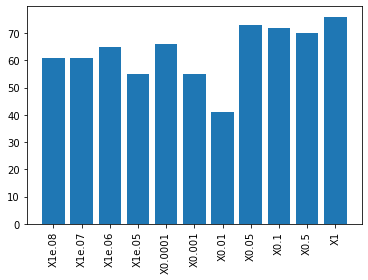

In [178]:
plt.bar(PRS_thresholds,[len(list(filter(lambda x: x<0.05,diffusion_term_p_val_ROIs[diffusion_term_p_val_ROIs['PRS_threshold']==threshold].loc[:,'prs_pval']))) for threshold in PRS_thresholds])
plt.xticks(rotation='vertical')

In [ ]:
diffusion_term_p_val_ROIs[diffusion_term_p_val_ROIs['PRS_threshold'].filter()]

In [171]:
diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in ['CAU.R_SOG.R','CAU.R_MOG.R','PAL.R_PCL.R','TPOmid.R_THA.R'] else False)]

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
1527,CAU.R_SOG.R,0.397299,0.191544,0.0730791,0.585685,0.90552,0.697604,0.214607,0.663863,X1e.08
1529,CAU.R_MOG.R,0.6207,0.693003,0.882247,0.150877,0.987798,0.246538,0.176945,0.302149,X1e.08
1803,PAL.R_PCL.R,0.855852,0.779127,0.470746,0.890325,0.817844,0.91293,0.279775,0.837431,X1e.08
2410,TPOmid.R_THA.R,0.73266,0.525345,0.716623,0.121095,0.679469,0.971265,0.718846,0.485892,X1e.08
4040,CAU.R_SOG.R,0.405493,0.180837,0.07115,0.580337,0.922287,0.691095,0.211536,0.791836,X1e.07
4042,CAU.R_MOG.R,0.628654,0.655978,0.905237,0.14822,0.964438,0.253996,0.1728,0.43837,X1e.07
4316,PAL.R_PCL.R,0.854435,0.786894,0.467055,0.888314,0.822958,0.915635,0.278316,0.880583,X1e.07
4923,TPOmid.R_THA.R,0.74185,0.534253,0.702298,0.121546,0.678735,0.965396,0.722754,0.511164,X1e.07
6553,CAU.R_SOG.R,0.383928,0.192692,0.0698015,0.587535,0.891105,0.699867,0.210942,0.521065,X1e.06
6555,CAU.R_MOG.R,0.633906,0.648789,0.913117,0.146265,0.957716,0.252376,0.16771,0.400263,X1e.06


Of these, only CAU.R_SOG.R showed consistent nominal significance across higher PRS thresholds

In [172]:
diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in ['CAU.R_SOG.R'] else False)]

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
1527,CAU.R_SOG.R,0.397299,0.191544,0.0730791,0.585685,0.90552,0.697604,0.214607,0.663863,X1e.08
4040,CAU.R_SOG.R,0.405493,0.180837,0.07115,0.580337,0.922287,0.691095,0.211536,0.791836,X1e.07
6553,CAU.R_SOG.R,0.383928,0.192692,0.0698015,0.587535,0.891105,0.699867,0.210942,0.521065,X1e.06
9066,CAU.R_SOG.R,0.392978,0.187259,0.0712153,0.57656,0.909467,0.702783,0.213027,0.627509,X1e.05
11579,CAU.R_SOG.R,0.344333,0.204858,0.070051,0.530469,0.865805,0.705173,0.232712,0.333378,X0.0001
14092,CAU.R_SOG.R,0.268645,0.230389,0.0740354,0.575032,0.786246,0.676486,0.262871,0.180954,X0.001
16605,CAU.R_SOG.R,0.173514,0.218737,0.0686738,0.599529,0.642998,0.766378,0.260197,0.112672,X0.01
19118,CAU.R_SOG.R,0.0846052,0.201968,0.0583407,0.617256,0.482436,0.744362,0.314669,0.0514321,X0.05
21631,CAU.R_SOG.R,0.0659298,0.196291,0.0562121,0.625832,0.457255,0.72375,0.338731,0.0410267,X0.1
24144,CAU.R_SOG.R,0.0405873,0.214395,0.0588269,0.680039,0.403141,0.773832,0.338588,0.0290905,X0.5


### Reducing the diffusion connectivity space with PCA

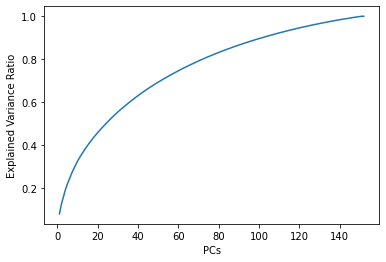

In [13]:
from sklearn.decomposition import PCA
diff_pca = StandardScaler().fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,remove_zero_features.reduced_features_names]))
pca = PCA()
diff_pca = pca.fit_transform(diff_pca)

plt.plot(np.arange(1,diff_pca.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')

european_diffusion_dataset_term['PC0_diff'] = diff_pca[:,0]

In [15]:
#reducing the whole dataset

In [16]:
european_diffusion_dataset_term['PC0_diff'] = diff_pca[:,0]

In [17]:
european_diffusion_term_pca_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in european_diffusion_dataset_term.columns if 'PRS' in i]):
    _, temp_model_summary = mass_univariate(european_diffusion_dataset_term, cat_independentVar_cols=['Gender'], cont_indpendentVar_cols=['GA_diff','PMA_diff','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold],dependentVar_cols=['PC0_diff'])
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    european_diffusion_term_pca_univariate = european_diffusion_term_pca_univariate.append(temp_model_summary)

european_diffusion_term_pca_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:00<00:00, 50.58it/s]


In [18]:
european_diffusion_term_pca_univariate

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,threshold
0,PC0_diff,0.136202,0.103514,-0.268866,0.023153,0.067087,0.374690,-0.730207,1.380709e-17,-0.066710,0.265170,-0.011363,0.846874,-0.063865,0.282399,0.037358,0.528707,PRS_1e-08
1,PC0_diff,0.136462,0.103008,-0.269379,0.022951,0.068078,0.367699,-0.730147,1.424257e-17,-0.067496,0.259810,-0.011180,0.849389,-0.063033,0.288718,0.030724,0.604337,PRS_1e-07
2,PC0_diff,0.137283,0.100983,-0.271000,0.022129,0.068905,0.361729,-0.730091,1.453720e-17,-0.068278,0.254055,-0.011224,0.848898,-0.062938,0.289574,0.025809,0.662861,PRS_1e-06
3,PC0_diff,0.137807,0.099819,-0.272034,0.021691,0.069498,0.357817,-0.730143,1.476578e-17,-0.069144,0.247701,-0.011296,0.848121,-0.063240,0.287522,0.019946,0.736456,PRS_1e-05
4,PC0_diff,0.138608,0.097048,-0.273616,0.020641,0.065570,0.384451,-0.731349,1.167800e-17,-0.064664,0.279350,-0.014474,0.805937,-0.064485,0.277062,0.054587,0.358829,PRS_0.0001
5,PC0_diff,0.137187,0.100547,-0.270811,0.021961,0.066957,0.374010,-0.731765,1.162473e-17,-0.063081,0.293747,-0.012401,0.832945,-0.066707,0.262185,0.051941,0.383052,PRS_0.001
6,PC0_diff,0.138692,0.096903,-0.273782,0.020590,0.063528,0.401061,-0.729645,1.327004e-17,-0.059837,0.324022,-0.012719,0.828743,-0.067267,0.258481,0.054029,0.371064,PRS_0.01
7,PC0_diff,0.136473,0.102400,-0.269402,0.022692,0.066535,0.377430,-0.732863,1.123574e-17,-0.059591,0.327954,-0.012003,0.838220,-0.069676,0.244782,0.051246,0.398894,PRS_0.05
8,PC0_diff,0.135407,0.104425,-0.267297,0.023508,0.063465,0.399423,-0.731895,1.021329e-17,-0.053825,0.378575,-0.012665,0.829079,-0.072826,0.223950,0.069607,0.253973,PRS_0.1
9,PC0_diff,0.135071,0.105608,-0.266633,0.024000,0.064387,0.392912,-0.729414,1.279999e-17,-0.054543,0.374321,-0.012939,0.825642,-0.071403,0.232926,0.063222,0.300593,PRS_0.5


In [17]:
# the lowest p-value for PC0 was 0.0339 and there were other significant p-value at PC5 and 8.

In [18]:
from scipy.stats import pearsonr
pearsonr(european_diffusion_dataset_term.loc[:,'PMA_diff'],data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[:,'PRS_0.05']),np.asarray(european_diffusion_dataset_term.loc[:,['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']])))

(0.12446932481323456, 0.1265520385894824)

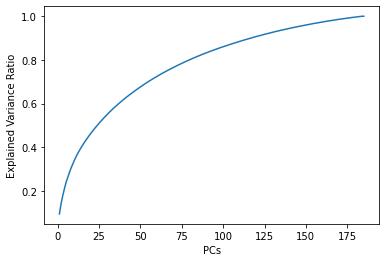

In [19]:
from sklearn.decomposition import PCA
diff_pca = StandardScaler().fit_transform(np.asarray(mixed_diffusion_dataset_term.loc[:,remove_zero_features.reduced_features_names]))
pca = PCA()
diff_pca = pca.fit_transform(diff_pca)

plt.plot(np.arange(1,diff_pca.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')

mixed_diffusion_dataset_term['PC0_diff'] = diff_pca[:,0]

In [20]:
mixed_diffusion_term_pca_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in mixed_diffusion_dataset_term.columns if 'PRS' in i]):
    _,temp_model_summary = mass_univariate(mixed_diffusion_dataset_term, cat_independentVar_cols=['Gender'], cont_indpendentVar_cols=['GA_diff','PMA_diff','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5',threshold],dependentVar_cols=['PC0_diff'])
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    mixed_diffusion_term_pca_univariate = mixed_diffusion_term_pca_univariate.append(temp_model_summary)

mixed_diffusion_term_pca_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:00<00:00, 54.20it/s]


In [21]:
mixed_diffusion_term_pca_univariate

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC2_pval,mixed_Anc_PC3_coef,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,threshold
0,PC0_diff,-0.105268,0.217676,0.214006,0.082992,-0.013896,0.863024,0.585587,6.450072e-12,0.047712,...,0.163053,-0.017903,0.810738,-0.071363,0.272921,-0.027013,0.672867,-0.009473,0.877010,PRS_1e-08
1,PC0_diff,-0.105164,0.218170,0.213794,0.083354,-0.013752,0.864388,0.585529,6.481325e-12,0.047426,...,0.162779,-0.017637,0.813650,-0.071333,0.273098,-0.027044,0.672403,-0.010767,0.860700,PRS_1e-07
2,PC0_diff,-0.105479,0.216670,0.214436,0.082256,-0.014380,0.858184,0.585638,6.456188e-12,0.048010,...,0.163247,-0.018090,0.808870,-0.071438,0.272497,-0.027257,0.669921,-0.006576,0.914510,PRS_1e-06
3,PC0_diff,-0.105537,0.216344,0.214554,0.082020,-0.016899,0.833601,0.586221,6.151377e-12,0.050518,...,0.164064,-0.020162,0.787840,-0.072347,0.266635,-0.027591,0.665960,0.013231,0.829592,PRS_1e-05
4,PC0_diff,-0.105602,0.216126,0.214686,0.081878,-0.014969,0.852374,0.585785,6.375391e-12,0.048472,...,0.162939,-0.018341,0.807139,-0.071579,0.271770,-0.027422,0.667969,-0.002232,0.971302,PRS_0.0001
5,PC0_diff,-0.105589,0.216220,0.214660,0.081966,-0.015257,0.849275,0.585847,6.306005e-12,0.048859,...,0.163106,-0.018683,0.803468,-0.071689,0.270542,-0.027462,0.667493,0.000158,0.997995,PRS_0.001
6,PC0_diff,-0.105770,0.215395,0.215027,0.081415,-0.013813,0.863792,0.585433,6.586783e-12,0.044800,...,0.168142,-0.016962,0.821701,-0.071889,0.269238,-0.027685,0.664958,-0.011333,0.865512,PRS_0.01
7,PC0_diff,-0.104098,0.222109,0.211627,0.085963,-0.011054,0.890306,0.586636,5.580249e-12,0.021959,...,0.180643,-0.010268,0.891586,-0.072755,0.262860,-0.030481,0.633627,-0.054327,0.458429,PRS_0.05
8,PC0_diff,-0.102366,0.228762,0.208107,0.090573,-0.006853,0.931778,0.585063,5.589780e-12,0.001880,...,0.194460,-0.003385,0.964175,-0.071306,0.271103,-0.032090,0.614836,-0.090940,0.228120,PRS_0.1
9,PC0_diff,-0.101240,0.233820,0.205817,0.094190,-0.005338,0.946858,0.582390,6.800252e-12,-0.010947,...,0.199382,-0.003188,0.966199,-0.069525,0.283137,-0.033578,0.598741,-0.102800,0.202525,PRS_0.5


### looking at the first PCs at the two extremes.

Correcting the first PC for the GA, PMA, Gender and Ancestry PCs

ttest showed significant differences in mean PCs between low and high risk groups (p=0.018) at 20%, but not at 25%, 30%, 


In [22]:

corrected_PC0 = data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term['PC0_diff']),StandardScaler().fit_transform(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']]))

high_risk, low_risk = data_preprocessing.high_low_risk_divide(data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term['PRS_0.05']),StandardScaler().fit_transform(european_diffusion_dataset_term[['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']])),low_perc=.2,high_perc=.2)

In [23]:
corrected_PC0_df=pd.DataFrame({'PC0':corrected_PC0,'risk':['high risk' if i in high_risk else 'low risk' if i in low_risk else np.nan for i in range(len(corrected_PC0))]}).dropna()

In [24]:
from scipy.stats import ttest_ind
ttest_ind(corrected_PC0_df[corrected_PC0_df['risk']=='low risk']['PC0'],corrected_PC0_df[corrected_PC0_df['risk']=='high risk']['PC0'],equal_var=True)

Ttest_indResult(statistic=-0.640315570567323, pvalue=0.5244053240975879)

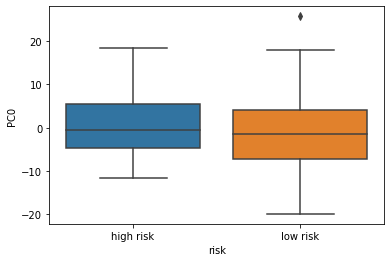

In [25]:
sns.boxplot(x='risk',y='PC0',data=corrected_PC0_df)

In [50]:
european_diffusion_dataset_term[['PC0_diff','GA_diff','PMA_diff','Gender','PRS_0.05','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']]

,PC0_diff,GA_diff,PMA_diff,Gender,PRS_0.05,euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3
0,-9.048619,39.000000,42.000000,1.0,-0.002568,0.039504,0.005096,0.011502
1,16.787308,39.714286,42.000000,1.0,-0.002409,-0.104926,0.017360,-0.081602
2,-12.470070,39.000000,42.857143,1.0,-0.002473,-0.131693,-0.071335,-0.005028
3,-15.841852,41.571429,42.857143,1.0,-0.002519,0.038875,0.025852,-0.040086
4,-21.370459,42.000000,43.285714,2.0,-0.002581,0.057020,-0.001994,-0.012540
...,...,...,...,...,...,...,...,...
147,-15.160833,41.285714,42.142857,2.0,-0.002459,0.022275,-0.027476,-0.007660
148,-10.043249,40.142857,43.714286,2.0,-0.002583,-0.058287,0.031794,0.008304
149,-11.878135,41.857143,42.000000,2.0,-0.002544,0.049823,-0.018725,0.004178
150,3.478842,37.714286,42.571429,2.0,-0.002514,0.039676,0.001762,0.035235


[0.5778532404624115, 0.9355937165306698, 0.8813055332692583, 0.19638160121434406]


[None]

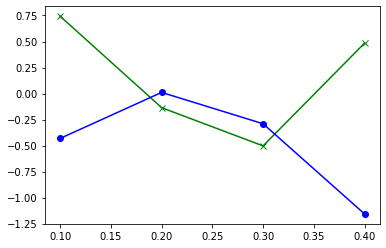

In [21]:
[draw_differences_across_percentages(mixed_diffusion_dataset_term,['PC0_diff'],['GA_diff','PMA_diff','Gender'],'PRS_1e-08',[0.1,0.2,0.3,0.4],['mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3'])]

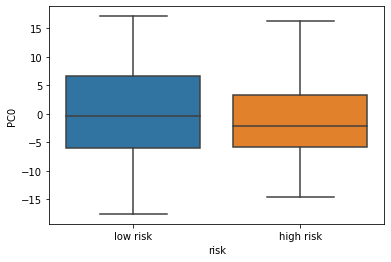

In [62]:

corrected_PC0 = data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(mixed_diffusion_dataset_term['PC0_diff']),StandardScaler().fit_transform(mixed_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']]))

high_risk, low_risk = data_preprocessing.high_low_risk_divide(data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(mixed_diffusion_dataset_term['PRS_0.05']),StandardScaler().fit_transform(mixed_diffusion_dataset_term[['mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5']])),low_perc=.3,high_perc=.3)

corrected_PC0_df=pd.DataFrame({'PC0':corrected_PC0,'risk':['high risk' if i in high_risk else 'low risk' if i in low_risk else np.nan for i in range(len(corrected_PC0))]}).dropna()

from scipy.stats import ttest_ind
ttest_ind(corrected_PC0_df[corrected_PC0_df['risk']=='low risk']['PC0'],corrected_PC0_df[corrected_PC0_df['risk']=='high risk']['PC0'],equal_var=True)


sns.boxplot(x='risk',y='PC0',data=corrected_PC0_df)

## Volumetric

In [13]:
european_volumetric_dataset_term[~european_volumetric_dataset_term[['GA_vol','Gender','PRS_1']].isna().any(axis=1)].shape
mixed_volumetric_dataset_term[~mixed_volumetric_dataset_term[['GA_vol','Gender','PRS_1']].isna().any(axis=1)].shape



(250, 4605)

In [14]:
european_volumetric_term_mass_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in european_volumetric_dataset_term.columns if 'PRS' in i]):
    _,temp_model_summary = mass_univariate(european_volumetric_dataset_term,cat_independentVar_cols=['Gender'],cont_indpendentVar_cols=['GA_vol','PMA_vol','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold],dependentVar_cols=[i for i in european_volumetric_dataset_term.columns if 'Imperial' in i])
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    european_volumetric_term_mass_univariate = european_volumetric_term_mass_univariate.append(temp_model_summary)

european_volumetric_term_mass_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


In [15]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,threshold
774,Imperial 79,0.422229,8.146425e-08,-0.884459,8.679821e-14,-0.294135,2.439325e-05,0.587869,2.564387e-15,0.077365,0.178524,-0.010056,0.857929,0.034205,0.536845,-0.186445,0.001094,PRS_0.1
687,Imperial 79,0.420255,9.659445e-08,-0.880324,1.176322e-13,-0.295742,2.264527e-05,0.591037,2.161278e-15,0.082914,0.148248,-0.008967,0.873400,0.030178,0.585631,-0.180545,0.001495,PRS_0.05
948,Imperial 79,0.425524,7.337123e-08,-0.891362,7.260287e-14,-0.298729,1.958041e-05,0.585091,3.997073e-15,0.082178,0.153722,-0.010812,0.847948,0.032524,0.558476,-0.172730,0.002426,PRS_1
768,Imperial 73,0.270661,1.580434e-03,-0.566965,6.925476e-06,-0.247603,1.302344e-03,0.552849,9.366184e-12,-0.082282,0.199668,0.015481,0.804954,0.073881,0.232568,-0.189240,0.002910,PRS_0.1
537,Imperial 16,0.209506,2.389772e-03,-0.438861,1.552820e-05,-0.146617,1.737501e-02,0.771213,7.830645e-27,0.096233,0.061967,0.095412,0.059883,0.005424,0.912759,-0.150974,0.003017,PRS_0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Imperial 20,0.261704,2.564653e-05,-0.548201,3.026202e-09,-0.278845,7.483878e-07,0.899217,2.073469e-38,0.047784,0.292365,-0.039337,0.383183,-0.052982,0.230543,-0.000950,0.982912,PRS_1e-07
292,Imperial 32,0.227511,2.206425e-03,-0.476577,1.328743e-05,-0.285243,2.363252e-05,0.783665,1.107820e-24,0.048591,0.374422,0.017324,0.750384,0.065624,0.218864,-0.000932,0.986119,PRS_1e-05
43,Imperial 44,0.250951,9.995027e-04,-0.525676,2.915514e-06,-0.142072,3.648326e-02,0.707744,1.639998e-20,0.042521,0.448980,-0.031607,0.570974,0.011456,0.833776,0.000672,0.990234,PRS_1e-08
813,Imperial 31,0.196632,1.308303e-03,-0.411892,4.846998e-06,-0.140966,9.914885e-03,0.870568,3.398291e-37,0.001648,0.971188,-0.042116,0.347097,0.051227,0.246013,0.000114,0.997957,PRS_0.5


In [16]:
mixed_volumetric_term_mass_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in mixed_volumetric_dataset_term.columns if 'PRS' in i]):
    _,temp_model_summary = mass_univariate(mixed_volumetric_dataset_term, cat_independentVar_cols=['Gender'], cont_indpendentVar_cols=['GA_vol','PMA_vol','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5',threshold],dependentVar_cols=[i for i in mixed_volumetric_dataset_term.columns if 'Imperial' in i])
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    mixed_volumetric_term_mass_univariate = mixed_volumetric_term_mass_univariate.append(temp_model_summary)

mixed_volumetric_term_mass_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:01<00:00,  6.13it/s]


In [17]:
mixed_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC2_pval,mixed_Anc_PC3_coef,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,threshold
681,Imperial 73,0.270670,3.173582e-04,-0.588413,2.482262e-07,-0.246257,3.156132e-04,0.554017,1.954922e-14,0.006269,...,0.030850,-0.011468,0.834361,0.019095,0.746247,-0.020453,0.719954,-0.227876,0.000522,PRS_0.05
768,Imperial 73,0.273287,2.854441e-04,-0.594101,2.018628e-07,-0.244496,3.563207e-04,0.550541,2.901473e-14,-0.000984,...,0.027667,-0.008681,0.874852,0.023620,0.689440,-0.019488,0.733087,-0.227447,0.000847,PRS_0.1
687,Imperial 79,0.427981,1.146826e-09,-0.930394,1.658015e-17,-0.295080,2.735219e-06,0.562396,4.095277e-17,0.029820,...,0.074842,-0.086287,0.085310,0.016094,0.764803,-0.005766,0.911706,-0.191939,0.001323,PRS_0.05
774,Imperial 79,0.430180,9.753754e-10,-0.935173,1.233481e-17,-0.293571,3.099952e-06,0.559674,5.513138e-17,0.021151,...,0.087376,-0.083305,0.097881,0.019893,0.711641,-0.005201,0.920361,-0.196218,0.001547,PRS_0.1
600,Imperial 79,0.419298,2.549773e-09,-0.911517,7.663288e-17,-0.291684,3.626031e-06,0.558331,6.580699e-17,0.062482,...,0.073212,-0.094384,0.058836,0.015957,0.767061,0.000002,0.999974,-0.171218,0.001868,PRS_0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Imperial 41,0.229398,1.540438e-03,-0.498692,5.450753e-06,-0.276883,2.988030e-05,0.651316,1.002809e-19,0.124925,...,0.331983,-0.154258,0.003538,0.022905,0.687790,-0.003661,0.946891,0.000995,0.985041,PRS_1e-05
105,Imperial 19,0.219978,3.038064e-04,-0.478212,2.297097e-07,-0.245489,1.066301e-05,0.831360,9.515630e-37,0.101617,...,0.041540,-0.054846,0.213240,0.026040,0.585905,0.013528,0.769228,-0.000577,0.989601,PRS_1e-07
485,Imperial 51,0.214404,5.597523e-03,-0.466095,6.628648e-05,-0.303455,1.983272e-05,0.590673,3.757471e-15,0.059925,...,0.973504,-0.008189,0.884144,0.040099,0.511285,-0.052045,0.377158,-0.000470,0.993588,PRS_0.001
132,Imperial 46,0.207200,2.355384e-04,-0.450434,1.404848e-07,-0.227326,1.036718e-05,0.889388,9.578065e-45,0.036927,...,0.257885,-0.055436,0.173789,0.002904,0.947605,0.028921,0.497741,-0.000129,0.997490,PRS_1e-07


In [18]:
def Imperial_volumes(df):
    new_df = df.copy()
    pipe0 = Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=1))])
    Imperial_vols=new_df[[i for i in df.columns if 'Imperial' in i]].copy()
    new_df['GM_sum_Imperial'] = Imperial_vols.iloc[:,np.r_[4:16,19:39]].sum(axis=1)
    new_df['GM_mean_Imperial'] = Imperial_vols.iloc[:,np.r_[4:16,19:39]].mean(axis=1)
    new_df['PC0_GM'] = pipe0.fit_transform(Imperial_vols.iloc[:,np.r_[4:16,19:39]].values)
    
    new_df['WM_sum_Imperial'] = Imperial_vols.iloc[:,50:82].sum(axis=1)
    new_df['WM_mean_Imperial'] = Imperial_vols.iloc[:,50:82].mean(axis=1)
    new_df['PC0_WM'] = pipe0.fit_transform(Imperial_vols.iloc[:,50:82].values)
    
    new_df['Deep_Gray_Imperial'] = Imperial_vols.iloc[:,np.r_[0:4,39:47,84:87]].sum(axis=1)

    new_df['Ventricles_Imperial'] = Imperial_vols.iloc[:,48:50].sum(axis=1)
    new_df['brainstem_Imperial'] = Imperial_vols.iloc[:,18]
    new_df['cerebellum_Imperial'] = Imperial_vols.iloc[:,16:18].sum(axis=1)
    new_df['CSF_Imperial'] = Imperial_vols.iloc[:,82]
    new_df['Intracranial_Imperial'] = new_df.loc[:,['GM_sum_Imperial','WM_sum_Imperial','Deep_Gray_Imperial','Ventricles_Imperial','brainstem_Imperial','cerebellum_Imperial','CSF_Imperial']].sum(axis=1)
    new_df['Total_Brain_Volume'] = new_df.loc[:,['GM_sum_Imperial','WM_sum_Imperial','Deep_Gray_Imperial','brainstem_Imperial','cerebellum_Imperial']].sum(axis=1)
    return new_df

In [19]:
european_volumetric_dataset_term = Imperial_volumes(european_volumetric_dataset_term)
mixed_volumetric_dataset_term = Imperial_volumes(mixed_volumetric_dataset_term)

In [20]:
european_volumetric= pd.DataFrame()
for threshold in tqdm.tqdm([i for i in european_volumetric_dataset_term.columns if 'PRS' in i]):
    _, temp_model_summary = mass_univariate(european_volumetric_dataset_term,['Gender'],['GA_vol','PMA_vol','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3','Intracranial_Imperial',threshold],['WM_sum_Imperial'])
    
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    european_volumetric = european_volumetric.append(temp_model_summary)

european_volumetric.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:00<00:00, 56.04it/s]


In [21]:
european_volumetric

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,threshold
0,WM_sum_Imperial,0.143903,0.000126,-0.301438,1.969616e-07,-0.037771,0.258464,-0.324631,7.066511e-10,-0.000782,0.976530,-0.022409,0.390948,-0.002336,0.927236,1.092014,3.744303e-63,-0.058536,0.023734,PRS_1e-08
1,WM_sum_Imperial,0.144618,0.000118,-0.302936,1.751462e-07,-0.038892,0.244776,-0.322879,9.038490e-10,-0.000171,0.994851,-0.022027,0.399470,-0.003387,0.894728,1.090110,5.922489e-63,-0.057371,0.026746,PRS_1e-07
2,WM_sum_Imperial,0.143575,0.000127,-0.300752,1.999562e-07,-0.038882,0.243811,-0.322454,8.688012e-10,-0.000364,0.989038,-0.021767,0.403983,-0.003500,0.890986,1.089589,4.561761e-63,-0.062188,0.016191,PRS_1e-06
3,WM_sum_Imperial,0.142279,0.000147,-0.298038,2.593299e-07,-0.038342,0.250655,-0.323404,7.834115e-10,0.000378,0.988618,-0.021393,0.412468,-0.002892,0.909853,1.090283,4.250016e-63,-0.061284,0.017834,PRS_1e-05
4,WM_sum_Imperial,0.142726,0.000146,-0.298973,2.547826e-07,-0.038912,0.244876,-0.322087,1.034788e-09,-0.000225,0.993245,-0.021971,0.401070,-0.002143,0.933301,1.089528,7.575707e-63,-0.055964,0.031364,PRS_0.0001
5,WM_sum_Imperial,0.143529,0.000127,-0.300656,1.992953e-07,-0.040718,0.222127,-0.318819,1.374728e-09,-0.002948,0.911713,-0.022880,0.379834,0.000470,0.985314,1.086952,7.648665e-63,-0.063510,0.014688,PRS_0.001
6,WM_sum_Imperial,0.143891,0.000129,-0.301414,2.051294e-07,-0.039631,0.236361,-0.317975,1.845644e-09,-0.003553,0.894502,-0.023380,0.371241,0.000802,0.975063,1.083685,3.953549e-62,-0.056337,0.032777,PRS_0.01
7,WM_sum_Imperial,0.147258,0.000091,-0.308466,1.138816e-07,-0.040691,0.224122,-0.316296,2.349203e-09,-0.003446,0.897634,-0.022878,0.381692,0.002923,0.909566,1.082927,5.034503e-62,-0.056501,0.032499,PRS_0.05
8,WM_sum_Imperial,0.147784,0.000091,-0.309569,1.149601e-07,-0.040523,0.227404,-0.317905,2.219758e-09,-0.003411,0.899354,-0.023474,0.370744,0.003214,0.901138,1.083156,1.047177e-61,-0.049494,0.063376,PRS_0.1
9,WM_sum_Imperial,0.147578,0.000099,-0.309137,1.344827e-07,-0.041327,0.220194,-0.321250,1.706794e-09,-0.001123,0.966852,-0.023771,0.366455,0.001870,0.942570,1.085846,1.188988e-61,-0.038476,0.148103,PRS_0.5


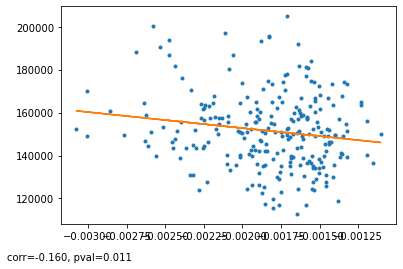

In [22]:
visualisation.plot_correlation(mixed_volumetric_dataset_term['PRS_0.001'],mixed_volumetric_dataset_term['WM_sum_Imperial'])

In [34]:
mixed_volumetric = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in mixed_volumetric_dataset_term.columns if 'PRS' in i]):
    _, temp_model_summary = mass_univariate(mixed_volumetric_dataset_term,['Gender'],['GA_vol','PMA_vol','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5','Intracranial_Imperial',threshold],['WM_sum_Imperial'])
    
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    mixed_volumetric = mixed_volumetric.append(temp_model_summary)

mixed_volumetric.reset_index(drop = True, inplace= True)




100%|██████████| 11/11 [00:00<00:00, 38.39it/s]


In [35]:
mixed_volumetric

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,threshold
0,WM_sum_Imperial,0.129791,0.000134,-0.282155,1.978852e-07,-0.015148,0.622253,-0.347270,9.865148e-13,0.023217,...,0.023097,0.020582,0.415874,-0.020051,0.411568,1.089865,7.921029e-77,-0.063096,0.007422,PRS_1e-08
1,WM_sum_Imperial,0.130881,0.000116,-0.284525,1.546241e-07,-0.016189,0.598302,-0.345382,1.283389e-12,0.021616,...,0.022195,0.020592,0.415325,-0.020609,0.398293,1.087884,1.164069e-76,-0.064653,0.006205,PRS_1e-07
2,WM_sum_Imperial,0.129839,0.000128,-0.282258,1.840417e-07,-0.016047,0.600902,-0.344919,1.265070e-12,0.020433,...,0.021002,0.020576,0.414918,-0.019873,0.414647,1.087221,9.941267e-77,-0.068035,0.004012,PRS_1e-06
3,WM_sum_Imperial,0.128322,0.000151,-0.278961,2.455479e-07,-0.015717,0.607905,-0.346156,9.695275e-13,0.018885,...,0.020798,0.021756,0.388254,-0.020950,0.389052,1.088231,5.759052e-77,-0.070912,0.002795,PRS_1e-05
4,WM_sum_Imperial,0.128370,0.000156,-0.279065,2.624826e-07,-0.016544,0.590255,-0.345454,1.255118e-12,0.016384,...,0.020369,0.021245,0.400737,-0.020486,0.401022,1.088270,1.005526e-76,-0.066046,0.005884,PRS_0.0001
5,WM_sum_Imperial,0.129431,0.000130,-0.281371,1.889517e-07,-0.019110,0.532737,-0.342583,1.630342e-12,0.009315,...,0.022678,0.019613,0.435931,-0.021128,0.384628,1.086748,7.140868e-77,-0.074601,0.002229,PRS_0.001
6,WM_sum_Imperial,0.129660,0.000139,-0.281869,2.124407e-07,-0.017224,0.576078,-0.342279,2.446460e-12,0.004213,...,0.030024,0.017319,0.494221,-0.023723,0.332246,1.084520,5.574772e-76,-0.065621,0.011377,PRS_0.01
7,WM_sum_Imperial,0.132993,0.000098,-0.289115,1.154585e-07,-0.018399,0.551551,-0.341622,3.242111e-12,-0.003703,...,0.038545,0.017574,0.488953,-0.025424,0.300767,1.084925,9.158991e-76,-0.064613,0.022074,PRS_0.05
8,WM_sum_Imperial,0.133456,0.000099,-0.290122,1.173650e-07,-0.017659,0.568898,-0.343977,2.740970e-12,-0.001076,...,0.038410,0.018878,0.458702,-0.024699,0.316289,1.086007,1.654906e-75,-0.055808,0.057118,PRS_0.1
9,WM_sum_Imperial,0.133337,0.000107,-0.289862,1.374186e-07,-0.017211,0.580268,-0.347498,1.999152e-12,0.003279,...,0.027989,0.019497,0.445926,-0.024939,0.314746,1.088674,2.137195e-75,-0.042059,0.184053,PRS_0.5


In [25]:
model1, _ = mass_univariate(mixed_volumetric_dataset_term,['Gender'],['GA_vol','PMA_vol','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5','Intracranial_Imperial','PRS_0.001'],['WM_sum_Imperial'])
model2, _ = mass_univariate(mixed_volumetric_dataset_term,['Gender'],['GA_vol','PMA_vol','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5','Intracranial_Imperial'],['WM_sum_Imperial'])


model1.rsquared_adj-model2.rsquared_adj

0.004668061184163297

In [75]:
model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.858   
Dependent Variable:   WM_sum_Imperial   AIC:                 174.4986
Date:                 2021-06-16 20:03  BIC:                 209.8629
No. Observations:     184               Log-Likelihood:      -76.249 
Df Model:             10                F-statistic:         111.7   
Df Residuals:         173               Prob (F-statistic):  4.97e-70
R-squared:            0.866             Scale:               0.14264 
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.1507   0.0417  3.6133 0.0004  0.0684  0.2330
Gender_2.0            -0.3081   0.0635 -4.8534 0.0000 -0.4333 -0.1828
GA_vol                -0.0090   0.0388 -0.2335 0.8157 -0.0855  0.0674
PMA_vol               -0.3528   0.0569 -6.2042 0.0000 -0.4650 -0.2406
mixed_Anc_PC1          0.0011   0.0326  0.0324 0.9742 -0.0632  0.0654
mixed_Anc_PC2         -0.0016   0.0344 -0.0469 0.9626 -0.0695  0.0663
mixed_Anc_PC3         -0.0332   0.0348 -0.9550 0.3409 -0.1019  0.0354
mixed_Anc_PC4         -0.0052   0.0302 -0.1712 0.8643 -0.0648  0.0544
mixed_Anc_PC5         -0.0028   0.0297 -0.0930 0.9260 -0.0613  0.0558
Intracranial_Imperial  1.0748   0.0479 22.4487 0.0000  0.9803  1.1693
PRS_0.001             -0.0850   0.0292 -2.9071 0.0041 -0.1427 -0.0273
---------------------------------------------------------------------
Omnibus:               6.816          Durbin-Watson:            2.090
Prob(Omnibus):         0.033          Jarque-Bera (JB):         7.665
Skew:                  -0.303         Prob(JB):                 0.022
Kurtosis:              3.795          Condition No.:            5    
=====================================================================

"""

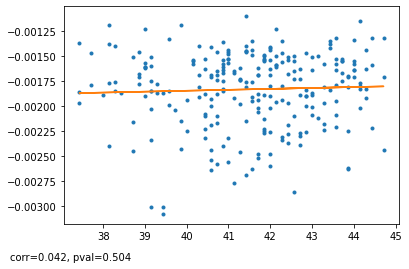

In [26]:
visualisation.plot_correlation(mixed_volumetric_dataset_term['PMA_vol'],mixed_volumetric_dataset_term['PRS_0.001'])

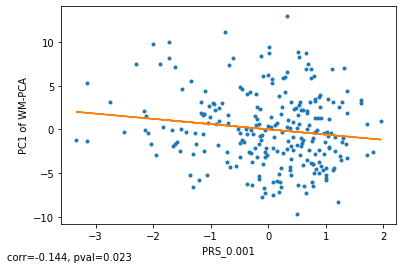

In [27]:
visualisation.plot_correlation(data_preprocessing.standardize_single_column(mixed_volumetric_dataset_term['PRS_0.001']),(mixed_volumetric_dataset_term['PC0_WM']),xlabel='PRS_0.001',ylabel='PC1 of WM-PCA')

[0.23078700930316928, 0.02681561222190954, 0.04873102946806251, 0.12603552484912867]
[0.2816897311123522, 0.06107183850701225, 0.035976687230530456, 0.056612986338909536]
[0.07588412684890049, 0.01957915397538361, 0.009772802755830652, 0.07007168528156366]
[0.0693506326967595, 0.016329707367652106, 0.015492297381399338, 0.019125153296042776]
[0.05832412716032492, 0.018068247263695596, 0.028186005569451753, 0.08607318616374685]
[0.023059923113711685, 0.006829216993180516, 0.0073242309873207965, 0.020363693954362244]
[0.05125444516751747, 0.06449009591206904, 0.01763376360024273, 0.023594549362629096]
[0.05609009612525977, 0.11410135370430664, 0.05699871324065072, 0.04276508462209154]
[0.041558969993418717, 0.17091545125701618, 0.1288839819019623, 0.3016954097292626]
[0.12634036077982388, 0.38651512777798, 0.40455338701689103, 0.7145808239250222]
[0.2148596688471949, 0.2752374902711996, 0.44477262329646894, 0.5884245646634858]


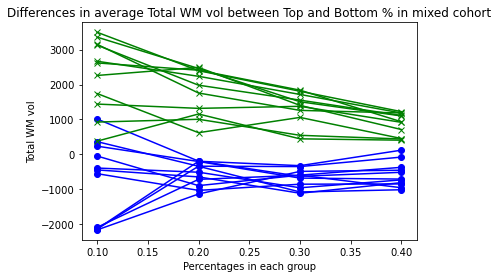

In [28]:
for threshold in [i for i in european_diffusion_dataset_term.columns if 'PRS' in i]:
    draw_differences_across_percentages(mixed_volumetric_dataset_term,dependentVar=['WM_sum_Imperial'],independentVar=['GA_vol','Gender','PMA_vol','Intracranial_Imperial'],threshold = threshold,percentages=[0.1,0.2,0.3,0.4],ancestry_PCs = ['mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5'])
    plt.title('Differences in average Total WM vol between Top and Bottom % in mixed cohort')
    plt.ylabel('Total WM vol')
    plt.xlabel('Percentages in each group')

[0.3556409631086346, 0.1415608630991518, 0.07790920991738386, 0.17681708754639566]
[0.5077249904797911, 0.049619987843258474, 0.16573063746853167, 0.19278873287705017]
[0.16038195668964855, 0.09854452809727103, 0.1481420819138287, 0.1886865974676422]
[0.1750542631984301, 0.08024126205275363, 0.11877668112015852, 0.06759852698211864]
[0.2892838108365614, 0.11861778990757235, 0.13249496098401245, 0.13532729948844488]
[0.20035435518106287, 0.0629235169016433, 0.06640635141960985, 0.1683575169495653]
[0.13738017231222824, 0.07574539179522538, 0.0468961568728098, 0.07407751051171292]
[0.25001210214558783, 0.1943918636041994, 0.1798704871844659, 0.32514022196588743]
[0.2908357151035477, 0.46997723331782015, 0.3855235533601339, 0.43442820290939277]
[0.4400596270301068, 0.8689771397054463, 0.5770072800813969, 0.722264968367004]
[0.4599434835305314, 0.7353863203539727, 0.7380759091711706, 0.735703381339014]


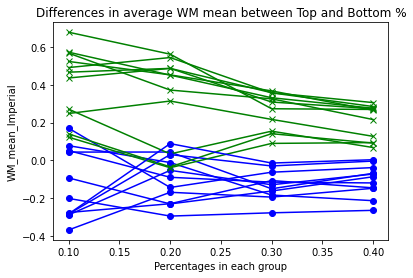

In [29]:
for threshold in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
    draw_differences_across_percentages(european_volumetric_dataset_term,dependentVar=['PC0_WM'],independentVar=['GA_vol','PMA_vol','Intracranial_Imperial'],threshold = threshold,percentages = [0.1,0.2,0.3,0.4],ancestry_PCs = ['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3'])
    plt.title('Differences in average WM mean between Top and Bottom %')
    plt.ylabel('WM_mean_Imperial')
    plt.xlabel('Percentages in each group')

## Microstructure

In [12]:
micro_labels = pd.read_excel(open('./dataset/microstructure/052021/dHCP-info-for-H_outcomes_and_rad_scores_05_2021.xlsx','rb'),sheet_name='wm_roi_notations')

In [13]:
def get_micro_label(micro_labels,list_of_labels):
    label_number = []
    for idx,name in enumerate(micro_labels['Name']):
        for label in list_of_labels:
            if label in name:
                label_number.append(micro_labels.loc[idx,'Label']) 
            
    return label_number


In [14]:
association_fibers_labels = get_micro_label(micro_labels,['fronto-occipital','uncinate_fasc','longitudinal_fasc'])
projection_fibers_labels = get_micro_label(micro_labels,['corticospinal','medial_lemniscus','cingulum','middle_cerebellar_peduncle'])

In [15]:
pipe0 = Pipeline([('scaler',StandardScaler()),
                  ('pca',PCA(n_components=1))])

for micro in tqdm.tqdm(['FA','MD','FISO','T2']):
    
    european_microstructure_dataset_term['Assoc_PCA_'+micro] = pipe0.fit_transform(european_microstructure_dataset_term.loc[:,['l'+str(i)+'_'+micro for i in association_fibers_labels]].values)
    
    european_microstructure_dataset_term['Assoc_sum'+micro] = european_microstructure_dataset_term.loc[:,['l'+str(i)+'_'+micro for i in association_fibers_labels]].sum(axis =1)
    
    european_microstructure_dataset_term['Assoc_mean'+micro] = european_microstructure_dataset_term.loc[:,['l'+str(i)+'_'+micro for i in association_fibers_labels]].mean(axis =1)
    
    
    european_microstructure_dataset_term['Proj_PCA_'+micro] = pipe0.fit_transform(european_microstructure_dataset_term.loc[:,['l'+str(i)+'_'+micro for i in projection_fibers_labels]].values)
    
    european_microstructure_dataset_term['Proj_sum'+micro] = european_microstructure_dataset_term.loc[:,['l'+str(i)+'_'+micro for i in projection_fibers_labels]].sum(axis =1)
    
    european_microstructure_dataset_term['Proj_mean'+micro] = european_microstructure_dataset_term.loc[:,['l'+str(i)+'_'+micro for i in projection_fibers_labels]].mean(axis =1)
    

100%|██████████| 4/4 [00:00<00:00, 17.07it/s]


In [16]:
european_microstructure_term_mass_univariate = pd.DataFrame()
for micro in tqdm.tqdm(['FA','MD','FISO','T12','T2']):
    for threshold in [i for i in european_microstructure_dataset_term.columns if 'PRS' in i]:
        dependentVariables = [i for i in european_microstructure_dataset_term.columns if micro in i]
        
        independentVariables = ['Gender','GA_micro', 'PMA_micro','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold]
        df = european_microstructure_dataset_term[dependentVariables+independentVariables].dropna()

        _,temp_model_summary = mass_univariate(df,cat_independentVar_cols=['Gender'],cont_indpendentVar_cols=['GA_micro','PMA_micro','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold],dependentVar_cols=dependentVariables,additional_info=micro)
        temp_model_summary.reset_index(drop = False,inplace=True)
        temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
        temp_model_summary['threshold'] = threshold
        european_microstructure_term_mass_univariate = european_microstructure_term_mass_univariate.append(temp_model_summary)

european_microstructure_term_mass_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


In [17]:
european_microstructure_term_mass_univariate[(european_microstructure_term_mass_univariate['Additional_info']=='FA') &(european_microstructure_term_mass_univariate['PRS_pval']<0.05)].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
617,l111_FA,0.015327,0.882180,-0.030458,0.835024,-0.035430,0.707802,0.349651,2.760500e-04,0.191217,0.011274,-0.067626,0.354822,-0.122321,0.098711,0.292794,0.000143,FA,PRS_1
557,l111_FA,0.017070,0.869011,-0.033921,0.816732,-0.035688,0.706034,0.351367,2.610954e-04,0.191368,0.011323,-0.068688,0.347883,-0.121945,0.100030,0.290357,0.000164,FA,PRS_0.5
497,l111_FA,0.023784,0.818478,-0.047262,0.747070,-0.036353,0.701186,0.344810,3.437031e-04,0.188490,0.012547,-0.064901,0.375259,-0.120166,0.105241,0.286726,0.000197,FA,PRS_0.1
437,l111_FA,0.026837,0.796942,-0.053330,0.717704,-0.036853,0.699145,0.340219,4.477690e-04,0.176175,0.019495,-0.067605,0.359121,-0.112223,0.131646,0.266660,0.000529,FA,PRS_0.05
257,l111_FA,0.038414,0.714126,-0.076335,0.607200,-0.054589,0.570420,0.363635,1.901454e-04,0.150996,0.043082,-0.063888,0.387732,-0.092146,0.215294,0.250342,0.001016,FA,PRS_0.0001
197,l111_FA,0.037919,0.718787,-0.075351,0.613359,-0.049976,0.604565,0.362016,2.144015e-04,0.145458,0.051833,-0.057985,0.434494,-0.088393,0.236364,0.235587,0.001962,FA,PRS_1e-05
377,l111_FA,0.036100,0.731983,-0.071737,0.630719,-0.046627,0.629079,0.359580,2.391765e-04,0.168008,0.026900,-0.062972,0.397060,-0.101436,0.175654,0.234084,0.002372,FA,PRS_0.01
137,l111_FA,0.031521,0.765586,-0.062637,0.675428,-0.045890,0.635778,0.360428,2.430844e-04,0.146247,0.051828,-0.056225,0.450607,-0.083767,0.264063,0.218197,0.004185,FA,PRS_1e-06
77,l111_FA,0.025627,0.808621,-0.050925,0.733618,-0.044110,0.649247,0.358154,2.699601e-04,0.147847,0.049833,-0.054843,0.462360,-0.083175,0.268126,0.212930,0.005216,FA,PRS_1e-07
493,l107_FA,-0.091778,0.380574,0.182380,0.218434,0.202309,0.035600,0.201839,3.507680e-02,-0.013604,0.856759,-0.036460,0.621141,-0.055548,0.456297,0.211526,0.005921,FA,PRS_0.1


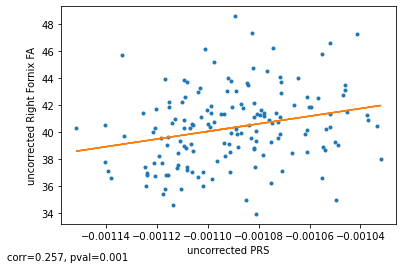

In [18]:
visualisation.plot_correlation(european_microstructure_dataset_term['PRS_1'],european_microstructure_dataset_term['l111_FA'],xlabel='uncorrected PRS',ylabel='uncorrected Right Fornix FA')

In [19]:
european_microstructure_term_mass_univariate.loc[[idx for idx,i in enumerate(european_microstructure_term_mass_univariate['Connection']) if 'Assoc_PCA_FA' in i],:].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
174,Assoc_PCA_FA,0.149486,0.045857,-0.297056,0.005331,0.049788,0.465348,-0.774610,3.264545e-22,-0.005588,0.915342,-0.016333,0.755203,-0.017201,0.743933,-0.051630,0.329369,FA,PRS_1e-06
234,Assoc_PCA_FA,0.148384,0.047662,-0.294866,0.005746,0.050056,0.463335,-0.774925,3.223602e-22,-0.005012,0.923996,-0.016062,0.759212,-0.016092,0.759886,-0.050103,0.344467,FA,PRS_1e-05
474,Assoc_PCA_FA,0.150905,0.043836,-0.299875,0.004897,0.046835,0.491101,-0.770804,5.291787e-22,-0.010289,0.846841,-0.014436,0.783280,-0.011646,0.825634,-0.049579,0.356845,FA,PRS_0.05
294,Assoc_PCA_FA,0.148919,0.047011,-0.295929,0.005603,0.049813,0.466211,-0.775119,3.337170e-22,-0.005402,0.918279,-0.015241,0.771515,-0.015409,0.769955,-0.044182,0.406123,FA,PRS_0.0001
114,Assoc_PCA_FA,0.151031,0.043777,-0.300125,0.004885,0.048654,0.475788,-0.774112,3.639271e-22,-0.005398,0.918353,-0.016750,0.749359,-0.017164,0.744709,-0.043879,0.407258,FA,PRS_1e-07
54,Assoc_PCA_FA,0.150998,0.043864,-0.300061,0.004903,0.049208,0.471426,-0.774704,3.495686e-22,-0.005356,0.919013,-0.017131,0.743879,-0.016114,0.759785,-0.042158,0.426197,FA,PRS_1e-08
414,Assoc_PCA_FA,0.149697,0.046034,-0.297475,0.005389,0.047787,0.484104,-0.774401,3.755401e-22,-0.007473,0.888371,-0.015668,0.765487,-0.014069,0.789924,-0.035691,0.505899,FA,PRS_0.01
534,Assoc_PCA_FA,0.151691,0.043077,-0.301437,0.004742,0.045630,0.502912,-0.772705,4.721172e-22,-0.008350,0.876400,-0.015866,0.762645,-0.012396,0.815318,-0.032849,0.543560,FA,PRS_0.1
354,Assoc_PCA_FA,0.150837,0.044508,-0.299740,0.005055,0.045569,0.504041,-0.773985,4.162623e-22,-0.004401,0.933734,-0.016358,0.755628,-0.015179,0.773785,-0.023436,0.658959,FA,PRS_0.001
594,Assoc_PCA_FA,0.152253,0.042513,-0.302554,0.004631,0.044707,0.511929,-0.773917,4.335916e-22,-0.005151,0.923756,-0.016386,0.755509,-0.014064,0.791310,-0.016777,0.756726,FA,PRS_0.5


In [20]:
european_microstructure_term_pca_mass_univariate = pd.DataFrame()
for micro in tqdm.tqdm(['FA','MD','FISO','T12','T2']):
    for threshold in [i for i in european_microstructure_dataset_term.columns if 'PRS' in i]:
        dependentVariables = [i for i in european_microstructure_dataset_term.columns if micro in i]
        
        independentVariables = ['Gender','GA_micro', 'PMA_micro','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold]
        df = european_microstructure_dataset_term[dependentVariables+independentVariables].dropna()
        pipe0= Pipeline([('scaler',StandardScaler()),
                        ('pca',PCA(n_components=1))])
        df['PC0_'+micro] = pipe0.fit_transform(df[dependentVariables])

        df['sum_'+micro] = df[dependentVariables].sum(axis=1)
        df['mean_'+micro] = df[dependentVariables].mean(axis=1)
        
        _,temp_model_summary = mass_univariate(df,cat_independentVar_cols=['Gender'],cont_indpendentVar_cols=['GA_micro','PMA_micro','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold],dependentVar_cols=['PC0_'+micro],additional_info=micro)
        temp_model_summary.reset_index(drop = False,inplace=True)
        temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
        temp_model_summary['threshold'] = threshold
        european_microstructure_term_pca_mass_univariate = european_microstructure_term_pca_mass_univariate.append(temp_model_summary)
        
        
european_microstructure_term_pca_mass_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


In [21]:
european_microstructure_term_pca_mass_univariate

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
0,PC0_FA,0.115513,0.123477,-0.229545,0.031080,0.086317,0.209053,-0.799974,4.686143e-23,-0.009619,0.855661,-0.010590,0.840519,0.012893,0.807437,-0.066527,0.211694,FA,PRS_1e-08
1,PC0_FA,0.115587,0.123124,-0.229691,0.030920,0.085336,0.213546,-0.799047,4.987478e-23,-0.009599,0.855886,-0.010002,0.849235,0.011263,0.831406,-0.068262,0.199710,FA,PRS_1e-07
2,PC0_FA,0.113660,0.129474,-0.225862,0.033877,0.085993,0.210041,-0.799779,4.531087e-23,-0.009145,0.862467,-0.009544,0.856019,0.011434,0.828793,-0.070707,0.184067,FA,PRS_1e-06
3,PC0_FA,0.111669,0.136249,-0.221907,0.037198,0.087177,0.203807,-0.800281,4.101920e-23,-0.008811,0.867251,-0.009003,0.864009,0.012936,0.806524,-0.075207,0.157997,FA,PRS_1e-05
4,PC0_FA,0.111666,0.136067,-0.221901,0.037097,0.088353,0.198018,-0.800762,3.823986e-23,-0.010388,0.843933,-0.007224,0.890741,0.014106,0.789353,-0.077726,0.145719,FA,PRS_0.0001
5,PC0_FA,0.114250,0.128358,-0.227035,0.033372,0.082016,0.231705,-0.798503,5.985059e-23,-0.010490,0.843506,-0.008535,0.871465,0.015031,0.776752,-0.056596,0.289098,FA,PRS_0.001
6,PC0_FA,0.112703,0.133139,-0.223960,0.035675,0.085347,0.213651,-0.799501,4.856549e-23,-0.014868,0.780728,-0.007737,0.883247,0.016733,0.752101,-0.067839,0.208362,FA,PRS_0.01
7,PC0_FA,0.115489,0.123226,-0.229498,0.030965,0.082245,0.229090,-0.794212,8.321202e-23,-0.016450,0.758370,-0.006657,0.899435,0.019470,0.713702,-0.072818,0.178283,FA,PRS_0.05
8,PC0_FA,0.116527,0.120666,-0.231560,0.029820,0.081072,0.236663,-0.796442,7.484030e-23,-0.015872,0.768468,-0.008259,0.875582,0.019565,0.713571,-0.059231,0.276063,FA,PRS_0.1
9,PC0_FA,0.117617,0.118187,-0.233725,0.028746,0.079720,0.245680,-0.798457,7.179668e-23,-0.011404,0.833161,-0.008844,0.867276,0.017246,0.747016,-0.036326,0.505088,FA,PRS_0.5


[0.24148330462789674, 0.04611728389001182, 0.022233389054606867, 0.030998269845899457]
[0.22128699055581946, 0.04385212239218424, 0.018261037863060853, 0.017426542966984156]
[0.10874809767899228, 0.01849061060374228, 0.016096908571197232, 0.034735512746821316]
[0.06301969780117081, 0.015408417925843673, 0.010224692570381678, 0.026039748980830814]
[0.09428839470533262, 0.004135011314660514, 0.004390183993236887, 0.01591690596111147]
[0.32441681023875324, 0.02040442974895892, 0.0027909059110941535, 0.009465507753837697]
[0.06785272765908006, 0.003417429183667862, 0.000454638213627188, 0.008204973760707064]
[0.016023028997320724, 0.0022988745786022445, 0.0015384244164880565, 0.00018156608711529377]
[0.02076769088201225, 0.0016567417080893608, 1.9454452246289425e-06, 0.00014806862817137175]
[0.01915449271754322, 0.0002815285336304234, 2.6846162889952195e-05, 8.360749565341076e-05]
[0.010208494902461398, 0.0006424737475881649, 2.478562998825869e-05, 9.250246259174666e-05]


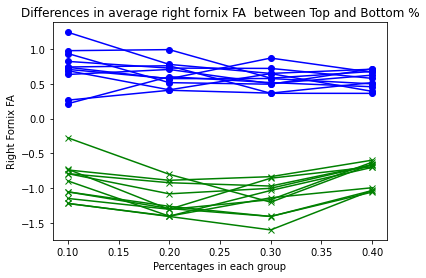

In [26]:
for threshold in [i for i in european_microstructure_dataset_term.columns if 'PRS' in i]:
    draw_differences_across_percentages(european_microstructure_dataset_term,dependentVar=['l111_FA'],independentVar=['GA_micro','Gender','PMA_micro'],threshold = threshold,percentages=[0.1,0.2,0.3,0.4],ancestry_PCs = ['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3'])
    plt.title('Differences in average '+'right fornix FA '+' between Top and Bottom %')
    plt.ylabel('Right Fornix FA')
    plt.xlabel('Percentages in each group')

In [60]:
european_microstructure_dataset_term['FA_sum'] = european_microstructure_dataset_term[[i for i in european_microstructure_dataset_term.columns if 'FA' in i]].mean(axis=1)

[0.008109050958991816, 0.06743572851186173, 0.034360210408978804, 0.14535597910982523]


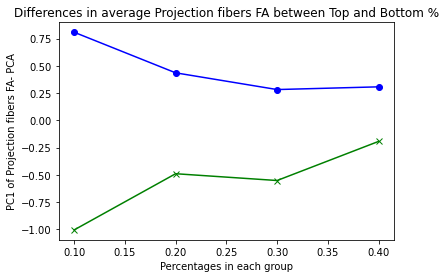

In [31]:
for threshold in [i for i in european_microstructure_dataset_term.columns if 'PRS_0.001' in i]:
    draw_differences_across_percentages(european_microstructure_dataset_term,dependentVar=['Proj_PCA_FA'],independentVar=['GA_micro','PMA_micro','Gender'],threshold = threshold,percentages = [0.1,0.2,0.3,0.4],ancestry_PCs = ['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3'])
    plt.title('Differences in average Projection fibers FA between Top and Bottom %')
    plt.ylabel('PC1 of Projection fibers FA- PCA')
    plt.xlabel('Percentages in each group')

# Ignore

In [5]:
european_diffusion_dataset_term_ver1 = pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_term_dataset.csv')

european_volumetric_dataset_term_ver1 = pd.read_csv('./preprocessed_data/volumetric/term/european_volumetric_term_dataset.csv')

european_microstructure_dataset_term_ver1 = pd.read_csv('./preprocessed_data/microstructure/term/european_microstructure_term_dataset.csv')


mixed_diffusion_dataset_term_ver1 = pd.read_csv('./preprocessed_data/diffusion/term/mixed_diffusion_term_dataset.csv')

mixed_volumetric_dataset_term_ver1 = pd.read_csv('./preprocessed_data/volumetric/term/mixed_volumetric_term_dataset.csv')

In [6]:
european_diffusion_dataset_term_ver2 = pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_term_dataset_ver2.csv')

european_volumetric_dataset_term_ver2 = pd.read_csv('./preprocessed_data/volumetric/term/european_volumetric_term_dataset_ver2.csv')

european_microstructure_dataset_term_ver2 = pd.read_csv('./preprocessed_data/microstructure/term/european_microstructure_term_dataset_ver2.csv')


mixed_diffusion_dataset_term_ver2 = pd.read_csv('./preprocessed_data/diffusion/term/mixed_diffusion_term_dataset_ver2.csv')

mixed_volumetric_dataset_term_ver2 = pd.read_csv('./preprocessed_data/volumetric/term/mixed_volumetric_term_dataset_ver2.csv')

In [8]:

print('available number of subjects in each dataset before removing outliers')
pd.DataFrame({'Dataset':['Vol','Diff','Micro'],
             'euro_number':[european_volumetric_dataset_term_ver1.shape[0],european_diffusion_dataset_term_ver1.shape[0],european_microstructure_dataset_term_ver1.shape[0]],
              'mixed_number':[mixed_volumetric_dataset_term_ver1.shape[0],mixed_diffusion_dataset_term_ver1.shape[0],mixed_diffusion_dataset_term_ver1.shape[0]]})

available number of subjects in each dataset before removing outliers


,Dataset,euro_number,mixed_number
0,Vol,152,185
1,Diff,152,185
2,Micro,142,185


In [83]:
differences = mixed_volumetric_dataset_term_ver1.merge(mixed_volumetric_dataset_term_ver2,on='ID',how='right',suffixes=('_ver1','_ver2'))

In [84]:
differences = differences[differences['GA_vol_ver1'].isna()]

In [85]:
differences

,ID,Gender_ver1,GA_diff_ver1,PMA_diff_ver1,GA_vol_ver1,PMA_vol_ver1,17 ICV (all except bone)_ver1,17 TOTAL BRAIN TISSUE VOLUME (mm3)_ver1,"19 Volume Pallidum (Bilateral) AAL, careful with preterm_ver1","28 Volume Mesencephalon (right cerebellum) (AAL, careful with preterm!)_ver1",...,PRS_1e-05_ver2,PRS_0.0001_ver2,PRS_0.001_ver2,PRS_0.01_ver2,PRS_0.05_ver2,PRS_0.1_ver2,PRS_0.5_ver2,PRS_1_ver2,cohort_ver2,termness_ver2
185,CC00668XX17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004514,0.001294,-0.001553,-0.002641,-0.002458,-0.002211,-0.001398,-0.001085,european,term
186,CC00741XX16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004468,0.001341,-0.001640,-0.002785,-0.002530,-0.002268,-0.001441,-0.001120,european,term
187,CC00708XX15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004743,0.001659,-0.001425,-0.002682,-0.002410,-0.002150,-0.001364,-0.001058,european,term
188,CC00692XX17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002868,0.000480,-0.001970,-0.002777,-0.002485,-0.002207,-0.001407,-0.001090,european,term
189,CC00557XX13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003692,0.000918,-0.001891,-0.002749,-0.002490,-0.002207,-0.001391,-0.001082,european,term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,CC00054XX05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002886,0.000377,-0.001955,-0.002855,-0.002526,-0.002231,-0.001417,-0.001099,european,term
248,CC00050XX01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004492,0.001192,-0.001580,-0.002800,-0.002514,-0.002223,-0.001404,-0.001089,european,term
249,CC00769XX19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000533,-0.001054,-0.002560,-0.003115,-0.002621,-0.002300,-0.001449,-0.001128,european,term
250,CC00749XX24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003861,0.001041,-0.001580,-0.002693,-0.002470,-0.002181,-0.001389,-0.001081,european,term


In [86]:
mixed_volumetric_dataset_term = mixed_volumetric_dataset_term_ver2.merge(differences['ID'],on = 'ID')